In [27]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import copy
from importlib import reload
import matplotlib.pyplot as plt
import multiprocessing
from IPython.display import clear_output, display
import subprocess
import glob
from pathlib import Path
import os

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

cwd = Path(os.getcwd())

wavelength = 633e-9
fl = 450e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

lamD_per_pix = 3.45e-6 / (fl * wavelength/fsm_pupil_diam) # lamD per pixel
print(lamD_per_pix)

as_per_pix = lamD_per_pix * as_per_lamD
print(as_per_pix)

v_zero = np.array([[0,0,0]]).T
v_bias = np.array([[50,50,50]]).T

18.389524275269295 arcsec
0.08599262769878883
1.581363514561072 arcsec


In [28]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [63]:
npsf = 256
cam.set_roi(575, 900, npsf, client0)

In [6]:
cam.set_exptime(0.0001, client0)

INFO:utils:Got semaphore index 0.


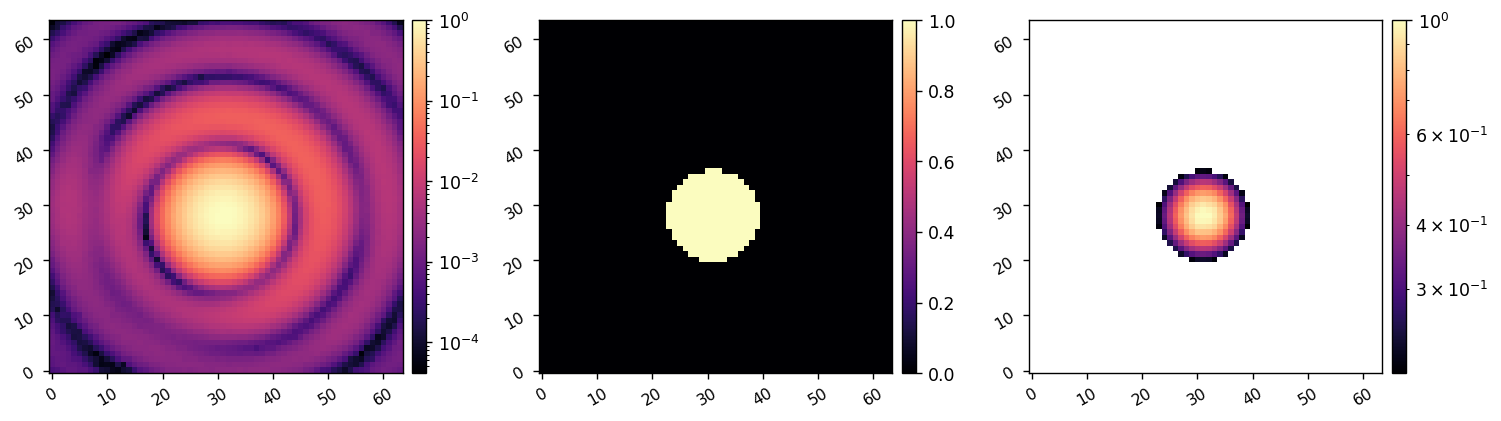

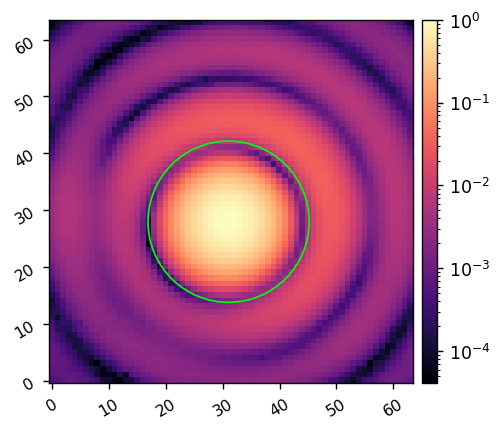

In [29]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.2, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/lamD_per_pix, fill=False, color='lime')])


In [27]:
im_bias.shape

(50, 52)

In [26]:
cam.cam_stream.shape


(52, 50, 1)

# Setup FSM Interface

In [30]:
fsm_bias_channel = ImageStream('dm00disp00')
fsm_channel = ImageStream('dm00disp10')

In [31]:
fsm_bias_channel.write(v_bias)

In [66]:
fsm_bias_channel.write(v_zero)
fsm_channel.write(v_zero)

# Setup the steps and record images

In [32]:
exp_dir = f'linearity-{today}'
exp_path = cwd/'data'/f'{exp_dir}'

subprocess.run(['mkdir',str(exp_path)])

CompletedProcess(args=['mkdir', '/home/uasal/Projects/fsm-exps/data/linearity-20250206'], returncode=0)

In [33]:
reload(fsm_utils)
fsm_utils.delete_all_data(exp_path)

In [35]:
Nsamps = 101
max_step = 10*u.arcsec
steps = np.linspace(-max_step, max_step, Nsamps)
v_steps = np.zeros((Nsamps, 3, 1))
for i in range(Nsamps):
    v_steps[i] = fsm_utils.get_fsm_volts(tip=steps[i], tilt=0*u.arcsec, dZ=0*u.um)
    # V = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=steps[i], , dZ=0*u.um)

tsleep = 0.5
cam.Nframes = 100

# v_steps

In [56]:
zero_ims = []
bias_ims = []
step_ims = []
return_ims = []

data = {
    'desired_steps':steps,
    'step_volts':v_steps,
    'N':Nsamps,
    'NFRAMES':cam.Nframes,
    'settling_time':tsleep,
    'FPS':client0[f'campupil.fps.current'],
    'EXPTIME':client0[f'campupil.exptime.current']
}

for i in range(Nsamps):
    fsm_bias_channel.write(v_zero)
    time.sleep(tsleep)
    zero_im = cam.snap()

    fsm_bias_channel.write(v_bias)
    time.sleep(tsleep)
    bias_im = cam.snap()

    fsm_channel.write(v_steps[i])
    time.sleep(tsleep)
    step_im = cam.snap()

    fsm_channel.write(v_zero)
    time.sleep(tsleep)
    return_im = cam.snap()

    zero_ims.append(copy.copy(zero_im))
    bias_ims.append(copy.copy(bias_im))
    step_ims.append(copy.copy(step_im))
    return_ims.append(copy.copy(return_im))

data.update({
    'zero_ims':np.array(zero_ims),
    'bias_ims':np.array(bias_ims),
    'step_ims':np.array(step_ims),
    'return_ims':np.array(return_ims),
})

In [57]:
utils.save_pickle(str(exp_path/f'tip.pkl'), data)

Saved data to:  /home/uasal/Projects/fsm-exps/data/linearity-20250205/tip.pkl


# Analyze data

In [14]:
exp_dir = f'linearity-20250205'
exp_path = cwd/'data'/f'{exp_dir}'

data_fname = 'tip.pkl'
data = utils.load_pickle(str(exp_path/data_fname))


In [15]:
N = data['N']
# N = 101
zero_ims = data['zero_ims']
bias_ims = data['bias_ims']
step_ims = data['step_ims']
return_ims = data['return_ims']

zero_cents = []
bias_cents = []
step_cents = []
return_cents = []

cthresh = 0.1

for i in range(N):
    zero_cents.append( utils.centroid(zero_ims[i], thresh=cthresh, plot=0) )
    bias_cents.append( utils.centroid(bias_ims[i], thresh=cthresh, plot=0) )
    step_cents.append( utils.centroid(step_ims[i], thresh=cthresh, plot=0) )
    return_cents.append( utils.centroid(return_ims[i], thresh=cthresh, plot=0) )
    
zero_cents = np.array(zero_cents)
bias_cents = np.array(bias_cents)
step_cents = np.array(step_cents)
return_cents = np.array(return_cents)

In [21]:
tip_diff = step_cents[75] - bias_cents[75]
print(tip_diff)

th_tip = np.arctan2(tip_diff[1], tip_diff[0]) * 180*u.degree/np.pi

print(th_tip)

[2.51938782 1.44209929]
29.786851084379567 deg


In [26]:
throt = -30*u.degree
throt = -th_tip
Mrot = np.array([
    [np.cos(throt), -np.sin(throt)],
    [np.sin(throt), np.cos(throt)],
])

tt = np.array([0,1])

Mrot@tt

array([0.4967748 , 0.86787948])

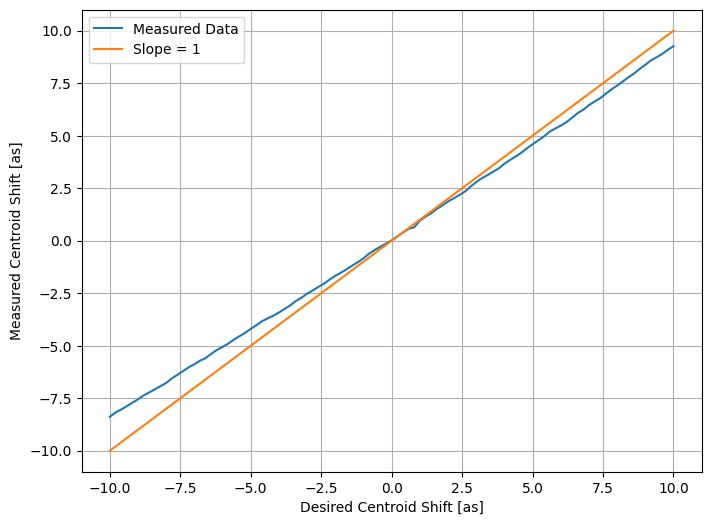

In [5]:
steps_pix = step_cents - bias_cents
steps_as = steps_pix * as_per_pix

total_steps_pix = np.sqrt( np.sum( np.square(steps_pix), axis=1) )
total_steps_pix[:N//2] *= -1

total_steps_as = total_steps_pix * as_per_pix

fig = plt.figure(figsize=(8,6))
plt.subplot(111)
plt.plot(data['desired_steps'], total_steps_as, label='Measured Data')
plt.plot(data['desired_steps'], data['desired_steps'], label='Slope = 1')
plt.grid()
plt.ylabel('Measured Centroid Shift [as]')
plt.xlabel('Desired Centroid Shift [as]')
# plt.xlim([-1,1])
# plt.ylim([-1,1])
plt.legend()

In [45]:
data['desired_steps']

<Quantity [-10. ,  -9.8,  -9.6,  -9.4,  -9.2,  -9. ,  -8.8,  -8.6,  -8.4,
            -8.2,  -8. ,  -7.8,  -7.6,  -7.4,  -7.2,  -7. ,  -6.8,  -6.6,
            -6.4,  -6.2,  -6. ,  -5.8,  -5.6,  -5.4,  -5.2,  -5. ,  -4.8,
            -4.6,  -4.4,  -4.2,  -4. ,  -3.8,  -3.6,  -3.4,  -3.2,  -3. ,
            -2.8,  -2.6,  -2.4,  -2.2,  -2. ,  -1.8,  -1.6,  -1.4,  -1.2,
            -1. ,  -0.8,  -0.6,  -0.4,  -0.2,   0. ,   0.2,   0.4,   0.6,
             0.8,   1. ,   1.2,   1.4,   1.6,   1.8,   2. ,   2.2,   2.4,
             2.6,   2.8,   3. ,   3.2,   3.4,   3.6,   3.8,   4. ,   4.2,
             4.4,   4.6,   4.8,   5. ,   5.2,   5.4,   5.6,   5.8,   6. ,
             6.2,   6.4,   6.6,   6.8,   7. ,   7.2,   7.4,   7.6,   7.8,
             8. ,   8.2,   8.4,   8.6,   8.8,   9. ,   9.2,   9.4,   9.6,
             9.8,  10. ] arcsec>

Text(0.5, 0, 'Desired Centroid Shift [as]')

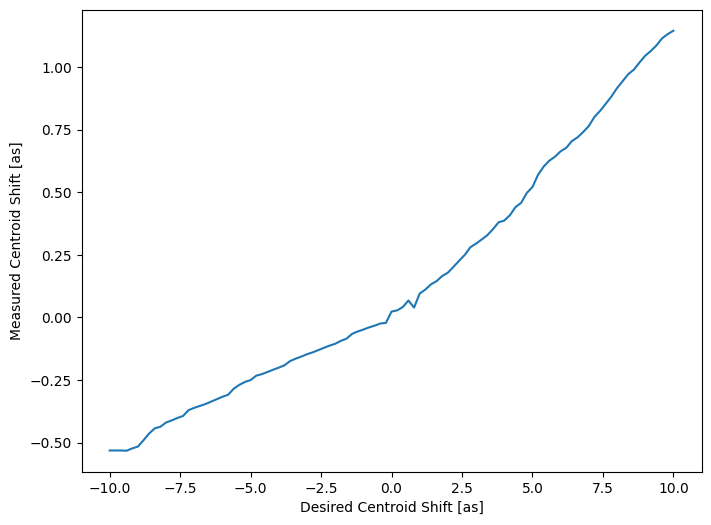

In [61]:
hyst_xy = return_cents - bias_cents 
hyst = np.sqrt( np.sum( np.square( hyst_xy ), axis=1) )
hyst[:N//2] *= -1

fig = plt.figure(figsize=(8,6))
plt.subplot(111)
plt.plot(data['desired_steps'], hyst, label='Measured Data')
# plt.plot(data['desired_steps'], data['desired_steps'], label='Slope = 1')
# plt.grid()
plt.ylabel('Measured Centroid Shift [as]')
plt.xlabel('Desired Centroid Shift [as]')
# plt.xlim([-1,1])
# plt.ylim([-1,1])
# plt.legend()